## Natural Language Processing
- Here we have used NLP techniques to analyse 2019 manifestos of BJP and Congress

## Installing required libraries

In [1]:
!pip install PyPDF2
!pip install pdfminer.six
!pip install pdfplumber
!pip install pdf2image
!pip install "gensim==4.2.0"
!pip install "texthero==1.0.5"
!pip install unidecode
!pip install en_core_web_trf

ERROR: Could not find a version that satisfies the requirement en_core_web_trf (from versions: none)
ERROR: No matching distribution found for en_core_web_trf


## Importing required libraries

In [2]:
# To read the PDF
import PyPDF2
# To analyze the PDF layout and extract text
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
# To extract text from tables in PDF
import pdfplumber
# To extract the images from the PDFs
from PIL import Image
from pdf2image import convert_from_path

import os
import pandas as pd
import numpy as np

# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NER libraries
import spacy
from spacy import displacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing PDF files





### Extracting Data form unstructured PDF

#### Helper functions for extacting data from PDF elements (tables and text)

In [3]:
# Function to extract text

def extractText(element) :
  # extracting text form inline text element
  line_text = element.get_text()

  # Format of text
  all_formats = []
  for text_line in element :
    if isinstance(text_line,LTTextContainer) :
      # Iterating through each character in the line of text
      for character in text_line :
        if isinstance(character,LTChar):
          # Add font name of the character to list of formats
          all_formats.append(character.fontname)
          # Add font size of the character to list of formats
          all_formats.append(character.size)

  # Unique fonts and sizes
  all_formats = list(set(all_formats))

  return line_text,all_formats

# Function to extract text from table elements of PDF

def extractTableText(filePath,pageNumber):
  # Opening PDF using pdfplumber
  pdf = pdfplumber.open(filePath)
  # Opening current page of PDF
  tablePage = pdf.pages[pageNumber]
  # Extracting table data from page
  table = tablePage.extract_tables()
  return table

#### Function for iterating through PDF

1. Ingest PDF files
2. Breaking down PDF pages into differnt components like TextBox and Tables
3. Extracting Text data from each of these elements

In [4]:
# Pre Processing PDF file

def preprocessPdf(filePath) :
  textFromDocument = []
  tableTextFromDocument = []

  # Extracting pages from pdf
  for pageNumber,page in enumerate(extract_pages(filePath)):

    # Variables for text extraction from page
    textOnPage = ''
    textFormatsOnPage = []

    # Variables for text extraction from tables
    textFromTablesonPage = []

    # Inspecting each element present on the page
    for element in page :
      # Checking if element is text element
      if isinstance(element,LTTextContainer) :
        textOfCurrentElement, formatOfCurrentElement = extractText(element)
        textOnPage += textOfCurrentElement
        textFormatsOnPage += formatOfCurrentElement
      # Checking if element is a table
      if isinstance(element,LTRect) :
        textFromTablesonPage += extractTableText(filePath,pageNumber)

    # Appending data from page to overall document data
    textFromDocument.append(textOnPage.replace('\n',''))
    tableTextFromDocument.append(textFromTablesonPage)

  return (textFromDocument,tableTextFromDocument)

### Extracting data from individual PDF files

In [5]:
# Extracting page wise data from PDF

pdfFilesPathList = ['/content/bjp_manifesto.pdf','/content/congress_manifesto.pdf']
dataFromPdfFiles = []

# Iterating through each file path and extracting data from the PDF files
for pdfFilePath in pdfFilesPathList :
  print(f'Currently processing file {pdfFilePath}')
  dataFromPdfFiles.append(preprocessPdf(pdfFilePath))

Currently processing file /content/bjp_manifesto.pdf
Currently processing file /content/congress_manifesto.pdf


### Converting extracted data to Pandas Dataframe


1.   Combining the text data extracted from PDF files into a pandas dataframe, with each row representing a page and its data




In [6]:
bjpDf = pd.DataFrame(list(zip(dataFromPdfFiles[0][0],dataFromPdfFiles[0][1])), columns = ['pageText','tableText'])
congressDf = pd.DataFrame(list(zip(dataFromPdfFiles[1][0],dataFromPdfFiles[1][1])), columns = ['pageText','tableText'])

# Dropping Table data and focusing on text data extracted from PDF page
bjpDf.drop(labels = ['tableText'],axis = 1, inplace = True)
congressDf.drop(labels = ['tableText'],axis = 1, inplace = True)

### Processing text for better analysis

The following steps are undertaken

*   Remove alphanumeric character
*   Lower case text
*   Remove Stop words
*   Lemmatise words
*   Remove words containing a mix of digits and alphabets
*   Removing words containing less than 4 characters





In [7]:
def textProcessor(text):

  # Removing non alpha numberic character except spaces
  text = re.sub("[^a-zA-Z0-9\\s]", " ",text)

  # Converting text to lower case
  text = text.lower()

  # Tokenising text
  text = word_tokenize(text)

  # Removing stop words
  stopwords = nltk.corpus.stopwords.words('english')
  text = [word for word in text if word not in stopwords]

  # Lemmatizing words
  wordnet_lemmatizer = WordNetLemmatizer()
  text = [wordnet_lemmatizer.lemmatize(word) for word in text]

  # Removing words containing numbers like 123crore
  text = [word for word in text if not any(c.isdigit() for c in word)]

  # Remving words with length less than 4
  text = [word for word in text if len(word)>=4]

  text = ' '.join(text)

  return text

In [8]:
dataFrames = [congressDf,bjpDf]
for df in dataFrames:
  df['processed_text'] = df['pageText'].apply(lambda x : textProcessor(x))

## Insight Generation

### Caculating TDIDF Scores for different words in the entire corpus
- TFIDF helps to identify the most important words for each document by comparing the words occurence in the document as well as the entire corpus

In [9]:
# Using TDIDF vectoriser from Sklearn

tfidf_scores = []
partyData = {'congress': congressDf, 'bjp' : bjpDf}
partyTfidf = {}
partyVectorisers = {}

for party in partyData:
  # initialize the vectorize
  vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=0.1, max_df=0.95)

  df = partyData[party]
  partyTfidf[party] = vectorizer.fit_transform(df['processed_text'])
  partyVectorisers[party] = vectorizer


### Clustering Data
- Creating clusters by applying KMeans algorithm on tfidf scores calculated previously

In [10]:
partyClusters = {}

for party in partyTfidf :
  # Creating clusters with 5 centroids
  kmeans = KMeans(n_clusters=4, random_state=20)
  # fit the model
  kmeans.fit(partyTfidf[party].toarray())
  # store cluster for each party
  partyClusters[party ]= kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Reducing Dimensionality of TFIDF vectors using PCA
- Dimensionality of vectors is reduced to 2 (*x and y axis*)
- This along with cluster data is used for visualisation

In [11]:
for party in partyClusters :
  # initialize PCA with 2 components
  pca = PCA(n_components=2, random_state=20)

  # Transforming TFIDF vector to two dimensions
  pca_vectors = pca.fit_transform(partyTfidf[party].toarray())

  # Saving dimension and cluster to the party data dataframes
  df = partyData[party]
  df ['cluster'] = partyClusters[party]
  df ['x0'] = pca_vectors[:,0]
  df ['x1'] = pca_vectors[:,1]


### Most important words for each cluster centroid

*  Finding important words of a cluster to understand what the clustered documents are talking about  


In [12]:
# Getting the most important words for each cluster centroid

for party in partyTfidf:
  print(f'Most important words for {party} for each cluster are')
  num_imp_words = 10

  tfidf_vector = partyTfidf[party]
  clusters = partyData[party]['cluster']
  temp_df = pd.DataFrame(tfidf_vector.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
  terms = partyVectorisers[party].get_feature_names_out() # access tf-idf terms

  for i,r in temp_df.iterrows():
      print('\nCluster {}'.format(i))
      print(','.join([terms[t] for t in np.argsort(r)[-num_imp_words:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

  print('-------------------')


Most important words for congress for each cluster are

Cluster 0
farmer,fear,people,economy,indian,voice,manifesto,choice,future,together

Cluster 1
fair,expert,national,election,committee,road,sabha,published,delhi,phase

Cluster 2
provide,good,public,year,central,body,business,state,government,promise

Cluster 3
hospital,police,defence,policy,people,border,government,promise,armed,force
-------------------
Most important words for bjp for each cluster are

Cluster 0
india,national,country,education,yojana,provide,scheme,pradhan,mantri,ensure

Cluster 1
indian,vision,modi,shri,narendra,government,year,nation,people,india

Cluster 2
policy,indian,cultural,accessible,time,right,india,woman,heritage,civil

Cluster 3
mission,ease,business,india,network,waste,road,ensure,centre,water
-------------------


### Visualising clusters

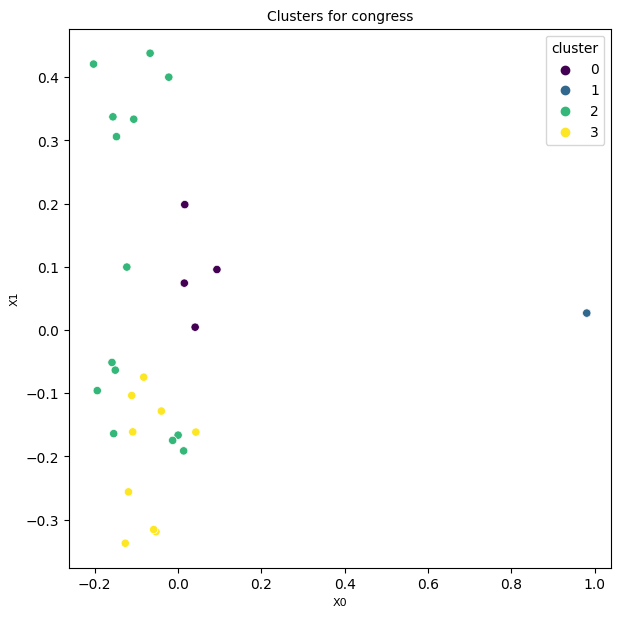

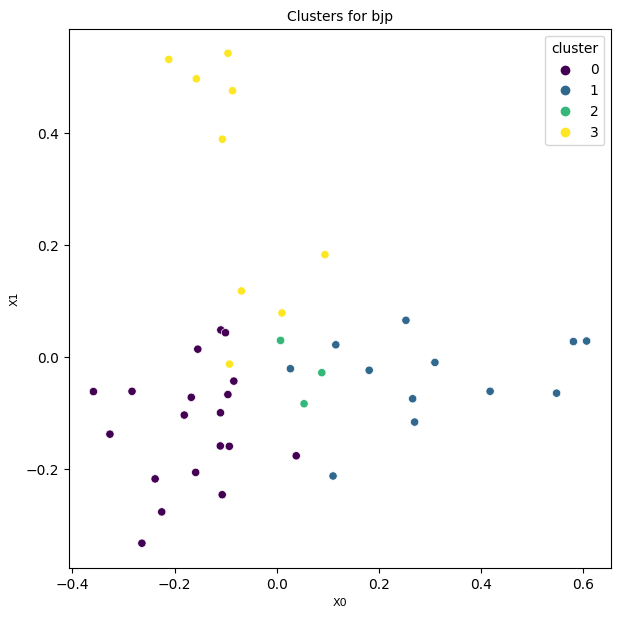

In [13]:
for party in partyData :
  # set figure size
  plt.figure(figsize=(7, 7))
  # set a title
  plt.title(f"Clusters for {party}", fontdict={"fontsize": 10})
  # set axes names
  plt.xlabel("X0", fontdict={"fontsize": 8})
  plt.ylabel("X1", fontdict={"fontsize": 8})
  # scatter plot with seaborn
  sns.scatterplot(data=partyData[party], x='x0', y='x1', hue='cluster', palette="viridis")
  plt.show()

### **Generating word clouds to see most popular words*

*   Word clouds help visualise the most frequently used in the corpus to understand what are the frequent occuring topics


#### BJP frequency distribution word cloud

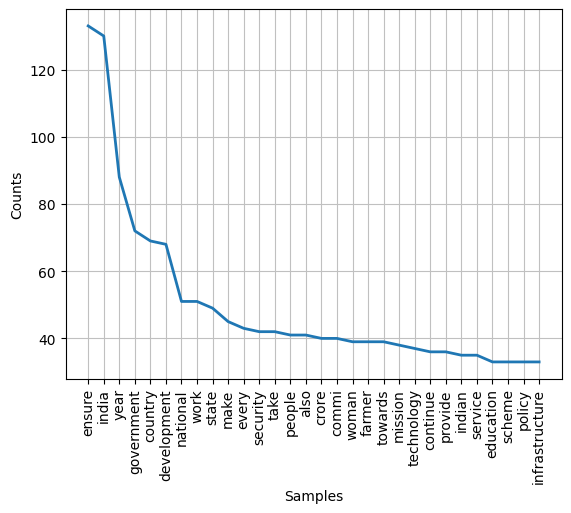

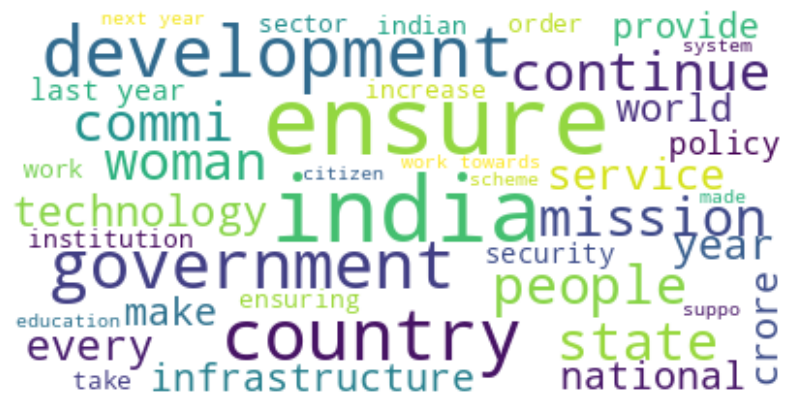

In [14]:
# Combining entire text of the report
corpus = ' '.join(partyData['bjp']['processed_text'])

# Create frequency distribution plot
fdist_corpus = corpus.split(' ')
fdist = FreqDist()
for word in fdist_corpus:
    fdist[word] += 1
fdist.plot(30)

# Generate a word cloud
wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(corpus)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Congress frequency distribution word cloud

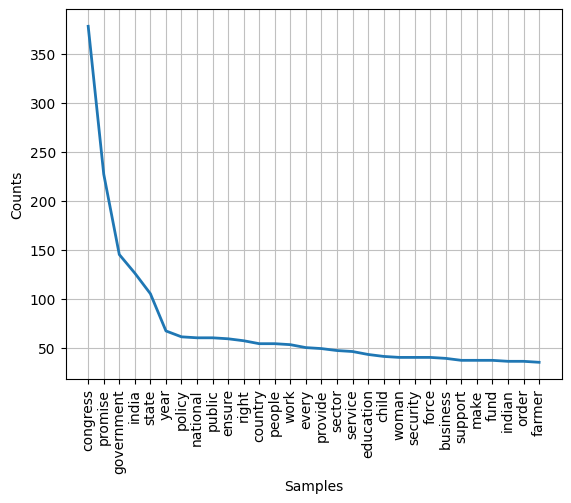

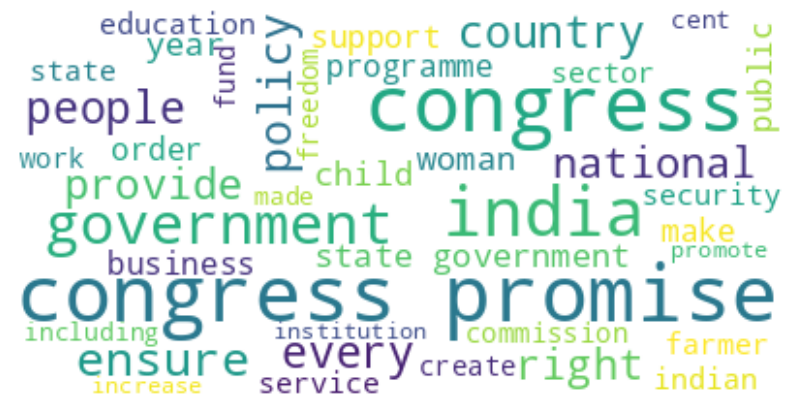

In [15]:
# Combining entire text of the report
corpus = ' '.join(partyData['congress']['processed_text'])

# Create frequency distribution plot
fdist_corpus = corpus.split(' ')
fdist = FreqDist()
for word in fdist_corpus:
    fdist[word] += 1
fdist.plot(30)

# Generate a word cloud
wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(corpus)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Comparing the most used words in both manifestos



*   Most occuring words display the difference in the topics the parties are talking about



In [16]:
df_most_used_words = pd.DataFrame()
for partyname in ['bjp','congress'] :

  # Combining entire text of the report
  corpus = ' '.join(partyData[partyname]['processed_text'])

  # frequency distribution
  fdist_corpus = corpus.split(' ')
  fdist = FreqDist()
  for word in fdist_corpus:
    fdist[word] += 1

  df_most_used_words[partyname] = [i[0] for i in fdist.most_common(35)]

print(df_most_used_words)

               bjp    congress
0           ensure    congress
1            india     promise
2             year  government
3       government       india
4          country       state
5      development        year
6         national      policy
7             work    national
8            state      public
9             make      ensure
10           every       right
11        security     country
12            take      people
13          people        work
14            also       every
15           crore     provide
16           commi      sector
17           woman     service
18          farmer   education
19         towards       child
20         mission       woman
21      technology    security
22        continue       force
23         provide    business
24          indian     support
25         service        make
26       education        fund
27          scheme      indian
28          policy       order
29  infrastructure      farmer
30           world   programme
31      

### **Named Entity recognition**


*  Finding the locations,organisations etc. discussed in the document



In [35]:
nlp = spacy.load('en_core_web_sm')

def nerDetector(corpus,entitiesToBeRecognised):

  valueDictionary = {}
  doc = nlp(corpus)

  for entity in doc.ents:
    if entity.label_ in entitiesToBeRecognised:
      entityName = entity.text
      if entityName in valueDictionary.keys():
        valueDictionary[entityName] += 1
      else :
        valueDictionary[entityName] = 1

  # sorting dictionary by value
  valueDictionary = dict(sorted(valueDictionary.items(), key=lambda x: x[1],reverse=True))
  return valueDictionary

In [37]:
# Locations/Countries mentioned by each party and their frequency
parties = ['bjp','congress']

for party in parties :

  print(f'------ {party} -------')
  # Text contained in party manifesto
  partyTextCorpus = ' '.join(partyData[party]['processed_text'])

  # Extracting locations from the text
  locations = nerDetector(partyTextCorpus,['GPE','LOC'])
  print(f'Locations/Countries discussed')
  print(locations)

  # Extracting organisation from the text
  organisations = nerDetector(partyTextCorpus,['ORG','NORP'])
  print(f'Organisations and nationalities discussed')
  print(organisations)

  print('\n')

------ bjp -------
Locations/Countries discussed
{'india': 100, 'yojana': 13, 'kashmir': 2, 'pakistan': 2, 'syama': 1, 'vandana': 1, 'anganwadi': 1, 'russia': 1}
Organisations and nationalities discussed
{'indian': 34, 'airpo': 3, 'pradhan mantri': 3, 'pradhan mantri kisan': 2, 'rese': 2, 'buddhist': 2, 'christian': 2, 'nancial suppo micro small medium': 2, 'pradhan': 2, 'muslim': 2, 'united nation security council': 2, 'united nation security': 1, 'barbaric force terror': 1, 'coin compound': 1, 'trinity dhan aadhaar': 1, 'bharatiya janata active': 1, 'mission antyodaya garib kalyan': 1, 'standing united development india': 1, 'ujjawala yojana': 1, 'congress': 1, 'swachh bharat health insurance ayushmaan bharat': 1, 'national highway': 1, 'free kisan': 1, 'jammu kashmir': 1, 'agricultural impo institute': 1, 'matsya sampada yojana': 1, 'digital india india': 1, 'kisan': 1, 'swachh bharat': 1, 'impo': 1, 'swachh': 1, 'bihari': 1, 'quantum': 1, 'bharat': 1, 'mbbs specialist doctor countr

## **QnA over PDF using GPT model**

#### Installing required libraries like Langchain and adding OpenAi API key


In [ ]:
!pip install langchain openai chromadb pypdf panel notebook
!pip install tiktoken
!pip install deeplake
!pip install deeplake[enterprise]

In [113]:
import os
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import panel as pn

In [114]:
# Setting up OpenAi API key

os.environ["OPENAI_API_KEY"] = ""

#### Setting up langchain for RetrievalQA
- The data used here is the text corpus collected from PDF file earlier

In [117]:
# Questions to ask LLM regarding the document
questions = ['What are the key issues discussed by Congress','Which states is Congress party focusing on and in which areas precisely?','What are the Congress opinions on Defense and miliary','What schemes has Congress discussed ?']

# split the documents into chunks
textCorpus = ' '.join(partyData['congress']['pageText'])
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500, chunk_overlap  = 500,)
texts = text_splitter.split_text(textCorpus)


# Generating embedding for text
embeddings = OpenAIEmbeddings()

# Creating vector store
db = Chroma.from_texts(texts, embeddings)

# Using this index in a retriever interface
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 6})

# Langchain to answer the question
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="refine", retriever=retriever, return_source_documents=True)

for question in questions :
  print(f'Question asked : {question}')
  result = qa({"query": question})
  print(f"Answer : {result['result']}")
  print('\n')


Question asked : What are the key issues discussed by Congress
Answer :  

The key issues discussed by Congress include enhancing the India Inclusive Innovation Fund to provide funds to innovative enterprises to scale-up and expand their operations, setting up a Scenario Planning and Strategic Futures Office to look at medium-to-long term strategic opportunities and risks for the country as an aid to informed policy making, setting up a National Data Science Institute with adequate funding and human resources to train and produce world-class Data Scientists, faster growth of the fisheries industry by establishing a separate Ministry of Fisheries and Welfare of Fisherfolk and recognizing inland fishing and aquaculture as ‘agriculture’, establishing a permanent mechanism with neighbouring countries to resolve problems faced by fisherfolk and improve the livelihood opportunities of the fishing community, increasing defence spending, taking strategic and hard measures to defend the territo